In [1]:
# Code from 
import torch
import math

dtype = torch.float
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)

# Create Tensors to hold input and outputs.
# By default, requires_grad=False, which indicates that we do not need to
# compute gradients with respect to these Tensors during the backward pass.
x = torch.linspace(-math.pi, math.pi, 2000, dtype=dtype)
y = torch.sin(x)

# Create random Tensors for weights. For a third order polynomial, we need
# 4 weights: y = a + b x + c x^2 + d x^3
# Setting requires_grad=True indicates that we want to compute gradients with
# respect to these Tensors during the backward pass.
a = torch.randn((), dtype=dtype, requires_grad=True)
b = torch.randn((), dtype=dtype, requires_grad=True)
c = torch.randn((), dtype=dtype, requires_grad=True)
d = torch.randn((), dtype=dtype, requires_grad=True)

learning_rate = 1e-6
for t in range(2000):
    # Forward pass: compute predicted y using operations on Tensors.
    y_pred = a + b * x + c * x ** 2 + d * x ** 3

    # Compute and print loss using operations on Tensors.
    # Now loss is a Tensor of shape (1,)
    # loss.item() gets the scalar value held in the loss.
    loss = (y_pred - y).pow(2).sum()
    if t % 100 == 99:
        print(t, loss.item())

    # Use autograd to compute the backward pass. This call will compute the
    # gradient of loss with respect to all Tensors with requires_grad=True.
    # After this call a.grad, b.grad. c.grad and d.grad will be Tensors holding
    # the gradient of the loss with respect to a, b, c, d respectively.
    loss.backward()

    # Manually update weights using gradient descent. Wrap in torch.no_grad()
    # because weights have requires_grad=True, but we don't need to track this
    # in autograd.
    with torch.no_grad():
        a -= learning_rate * a.grad
        b -= learning_rate * b.grad
        c -= learning_rate * c.grad
        d -= learning_rate * d.grad

        # Manually zero the gradients after updating weights
        a.grad = None
        b.grad = None
        c.grad = None
        d.grad = None

print(f'Result: y = {a.item()} + {b.item()} x + {c.item()} x^2 + {d.item()} x^3')

/home/jessica/miniconda3/envs/torch-test/lib/python3.12/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


99 234.6464385986328
199 163.62428283691406
299 115.06107330322266
399 81.81484985351562
499 59.02867889404297
599 43.393638610839844
699 32.65329360961914
799 25.26690673828125
899 20.181493759155273
999 16.676401138305664
1099 14.257966995239258
1199 12.5874662399292
1299 11.432380676269531
1399 10.632890701293945
1499 10.078971862792969
1599 9.694815635681152
1699 9.428139686584473
1799 9.242842674255371
1899 9.113981246948242
1999 9.024286270141602
Result: y = -0.01361696608364582 + 0.8504692912101746 x + 0.0023491543252021074 x^2 + -0.09243831783533096 x^3


In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("stock-data.csv")
df.info()
df.drop("Date", inplace=True, axis = 1)
df = df.replace(",","", regex = True)
df = df.astype(float)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737 entries, 0 to 736
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    737 non-null    object
 1   Open    737 non-null    object
 2   High    737 non-null    object
 3   Low     737 non-null    object
 4   Close   737 non-null    object
dtypes: object(5)
memory usage: 28.9+ KB


In [3]:
data = df[["Close"]]

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
data["Close"] = scaler.fit_transform(data["Close"].values.reshape(-1,1))
print(data.shape)

(737, 1)


/tmp/ipykernel_3149940/2017097845.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Close"] = scaler.fit_transform(data["Close"].values.reshape(-1,1))


In [5]:
# #we want to remove the decimal places that get added there incoorectly
# features = torch.round(torch.tensor(features, dtype = torch.float64)*100)/100

# #this is beacuse we want a 1D array for our answerers
# target = torch.round(torch.from_numpy(target)*100)/100


In [6]:
import torch.nn as nn
import torch.nn.functional as F

class stockPredictorLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(stockPredictorLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    #goes through each layer of the neural netwrok and returns an answer depending
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

model = stockPredictorLSTM(1,16,3,1)

In [7]:
#split training and validation sets manually
dataset = data.values

test_set_size = int(np.round(0.2*data.shape[0]))
train_set_size = data.shape[0] - test_set_size
print(test_set_size)
print(train_set_size)

train = dataset[0:train_set_size,:]
print(train.shape)

test = dataset[train_set_size:,:]
print(test.shape)

147
590
(590, 1)
(147, 1)


In [8]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy()
    data = []
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data)
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]
lookback = 21
x_train, y_train, x_test, y_test = split_data(data, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (573, 20, 1)
y_train.shape =  (573, 1)
x_test.shape =  (143, 20, 1)
y_test.shape =  (143, 1)


In [9]:
x_train_lstm = torch.from_numpy(x_train).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)

x_test_lstm = torch.from_numpy(x_test).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

In [10]:
print(type(x_train_lstm))

<class 'torch.Tensor'>


In [11]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

epochs = 1000
hist = np.zeros(epochs)
for epoch in range(epochs):
    y_train_pred = model.forward(x_train_lstm)

    loss = criterion(y_train_pred, y_train_lstm)
    if (epoch +1) %10 ==0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')
    hist[epoch] = loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

/home/jessica/miniconda3/envs/torch-test/lib/python3.12/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Epoch 9, Loss: 0.15487810969352722
Epoch 19, Loss: 0.0646325945854187
Epoch 29, Loss: 0.019593404605984688
Epoch 39, Loss: 0.009792209602892399
Epoch 49, Loss: 0.007173499092459679
Epoch 59, Loss: 0.00621873140335083
Epoch 69, Loss: 0.00574890011921525
Epoch 79, Loss: 0.005438452120870352
Epoch 89, Loss: 0.005156133323907852
Epoch 99, Loss: 0.004895923659205437
Epoch 109, Loss: 0.004656749311834574
Epoch 119, Loss: 0.004432127811014652
Epoch 129, Loss: 0.004220988135784864
Epoch 139, Loss: 0.004023042973130941
Epoch 149, Loss: 0.003838346106931567
Epoch 159, Loss: 0.0036668709944933653
Epoch 169, Loss: 0.003508981317281723
Epoch 179, Loss: 0.0033662046771496534
Epoch 189, Loss: 0.0032419664785265923
Epoch 199, Loss: 0.0031418248545378447
Epoch 209, Loss: 0.003071445971727371
Epoch 219, Loss: 0.003037611022591591
Epoch 229, Loss: 0.004032132215797901
Epoch 239, Loss: 0.0032644865568727255
Epoch 249, Loss: 0.0030328123830258846
Epoch 259, Loss: 0.003006201470270753
Epoch 269, Loss: 0.002

In [12]:
actuals = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))
print(actuals.head())
preds = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
print(preds.head())

             0
0  5187.700195
1  5180.740234
2  5127.790039
3  5064.199707
4  5018.390137
             0
0  5171.377930
1  5175.285645
2  5162.176270
3  5112.902344
4  5062.838379


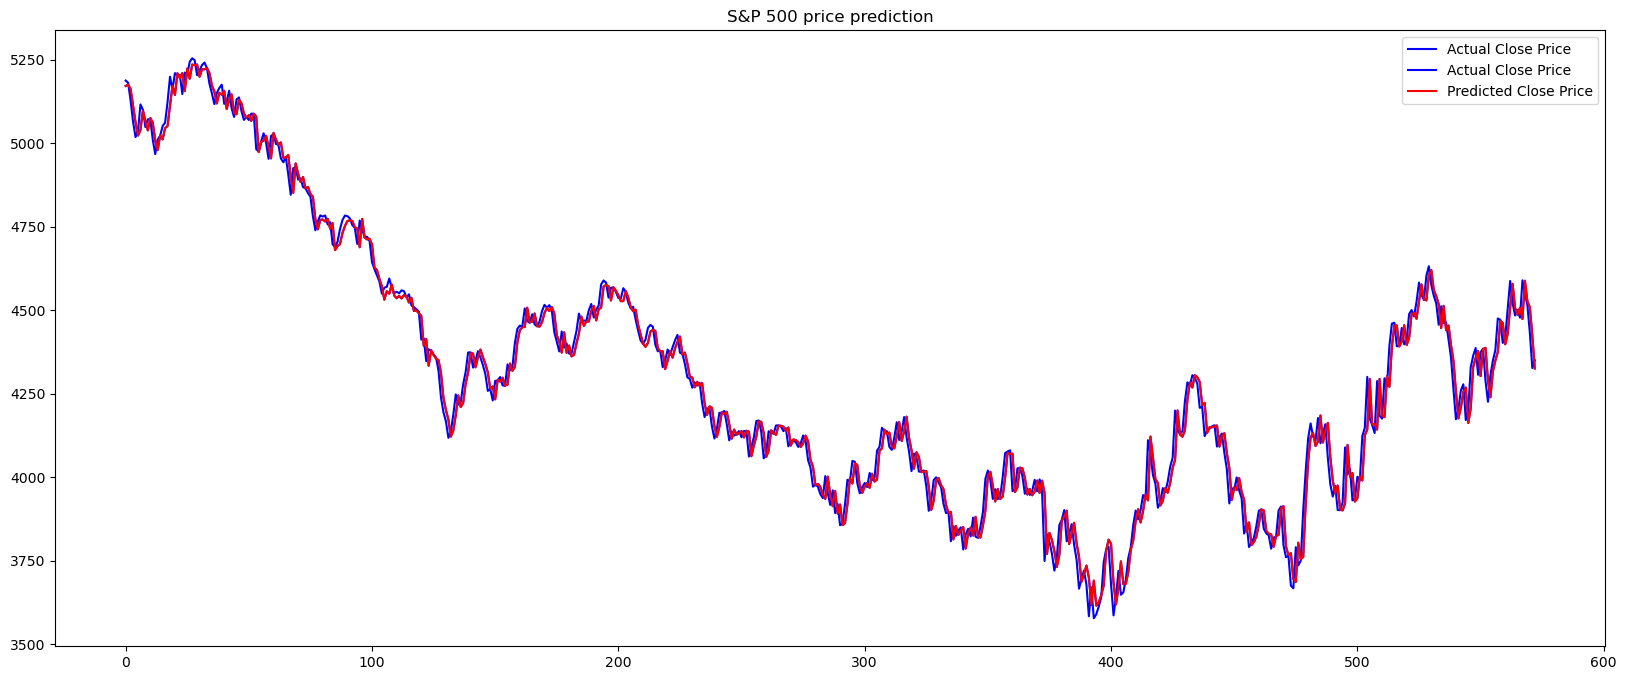

In [13]:
#Plot all predictions
import matplotlib.pyplot as plt

train = data[0:len(actuals)]
valid = actuals
valid['Predictions'] = preds
plt.figure(figsize=(20,8))
plt.plot(valid, color = 'blue', label = 'Actual Close Price')
plt.plot(valid['Predictions'], color = 'red', label = 'Predicted Close Price')
plt.title('S&P 500 price prediction')
plt.legend()
plt.show()

In [14]:
# make predictions
y_test_pred = model(x_test_lstm)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())

y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

In [15]:
from sklearn.metrics import mean_squared_error
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_train_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 47.21 RMSE


ValueError: Found input variables with inconsistent numbers of samples: [143, 573]

Actual Close Scalar
         0
0  5354.03
1  5291.34
2  5283.40
3  5277.51
4  5235.48
Predicted Close Scalar
             0
0  4358.029785
1  4348.329102
2  4399.580078
3  4381.716797
4  4472.800293


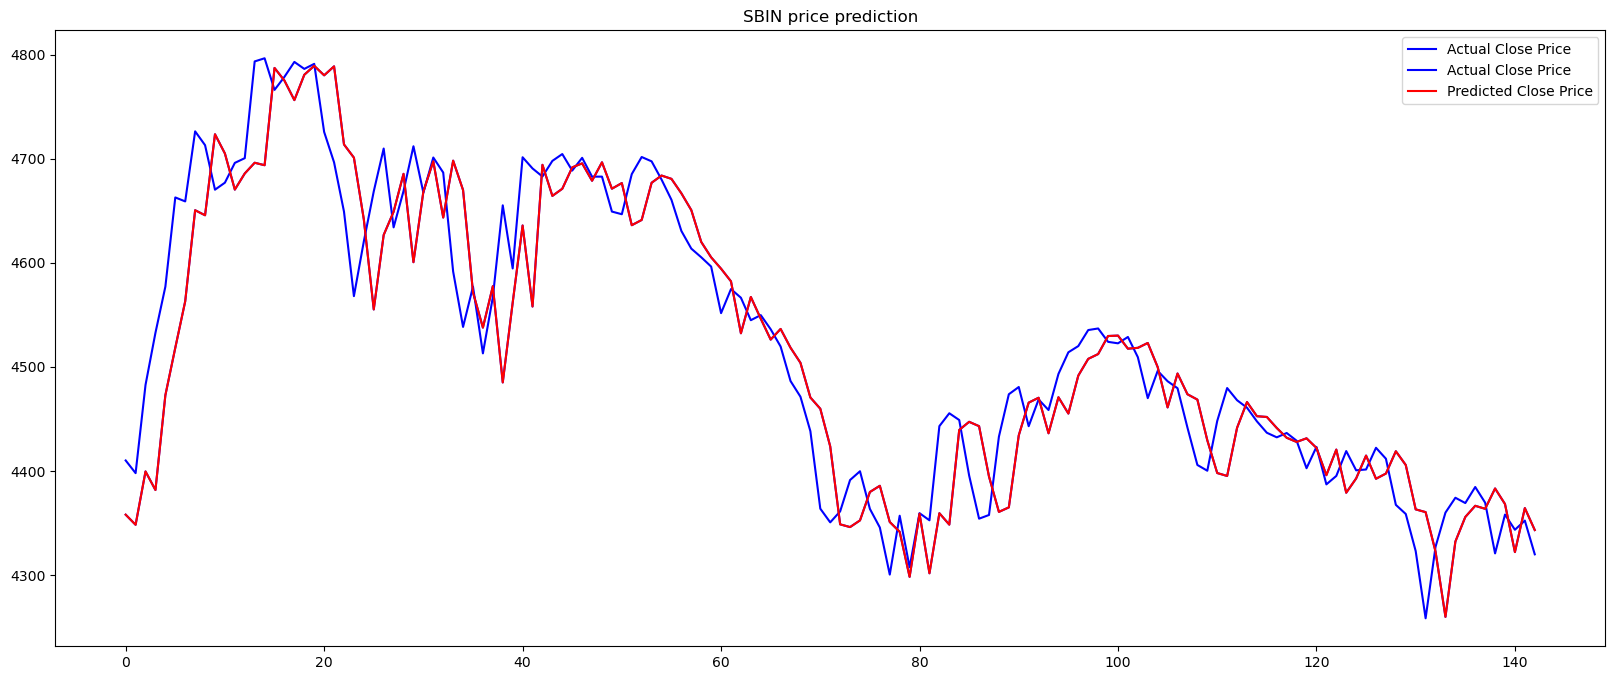

In [16]:
#Shift test predictions for plotting
original = scaler.inverse_transform(data['Close'].values.reshape(-1,1))
actuals = pd.DataFrame(original)
print("Actual Close Scalar")
print(actuals.head())
preds = pd.DataFrame(y_test_pred)
print("Predicted Close Scalar")
print(preds.head())

#Prepare actual close entries
aScalar = actuals[len(data) - len(preds):len(data)]

#Reset indexes for actuals for last 1037 entries
aScalar = aScalar.reset_index(drop=True)

#Plot predictions/actuals close price for test entries
valid = aScalar
valid['Predictions'] = preds
plt.figure(figsize=(20,8))
plt.plot(valid, color = 'blue', label = 'Actual Close Price')
plt.plot(valid['Predictions'], color = 'red', label = 'Predicted Close Price')
plt.title('SBIN price prediction')
plt.legend()
plt.show()